# Domácí úkol 3
## 0. Z obou datových souborů načtěte texty k analýze. Pro každý text zvlášť zjistěte absolutní četnosti jednotlivých znaků (symbolů včetně mezery), které se v textech vyskytují. Dále předpokládejme, že **první** text je vygenerován z homogenního markovského řetězce s diskrétním časem.

In [31]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
import matplotlib
from scipy import stats

plt.rcParams['figure.figsize'] = [15, 15]
plt.style.use('seaborn-darkgrid')
plt.rcParams["axes.grid"] = False
fontsize = 16

f1 = open('../source/011.txt', 'r')
f2 = open('../source/006.txt', 'r')

In [32]:
def unique_from_list(l: list) -> list:
    l_set = set(l)
    return [v for v in sorted(l_set, reverse=False)]

def char_frequencies(file):
    # Read lines except the first one
    lines = file.readlines()[1:]

    # Parse lines to characters
    chars = []
    for l in lines:
        chars.extend(c for c in l)

    num_chars = len(chars)
    unique_chars = unique_from_list(chars)

    # Count char frequencies
    occ = {}
    # occ = {
    #     'a': {
    #         'count': 5,
    #         'a': 0,
    #         'b': 1,
    #         'c': 3,
    #         ...
    #     },
    #     'b': {
    #         'count': 2,
    #         'a': 3,
    #         ...
    #     }
    # }

    # Init occ
    for c in unique_chars:
        occ[c] = {'count': 0}
        for cc in unique_chars:
            occ[c][cc] = 0


    for i in range(len(chars)):
        if i + 1 < len(chars):
            i_c = chars[i]
            j_c = chars[i + 1]
            occ[i_c]['count'] += 1
            occ[i_c][j_c] += 1

    return occ, unique_chars, num_chars

freq_1, unique_chars_1, num_chars_1 = char_frequencies(f1)
freq_2, unique_chars_2, num_chars_2 = char_frequencies(f2)

## 1. Za předpokladu výše odhadněte matici přechodu markovského řetězce pro **první** text. Odhadnuté pravděpodobnosti přechodu vhodně graficky znázorněte, např. použitím heatmapy.

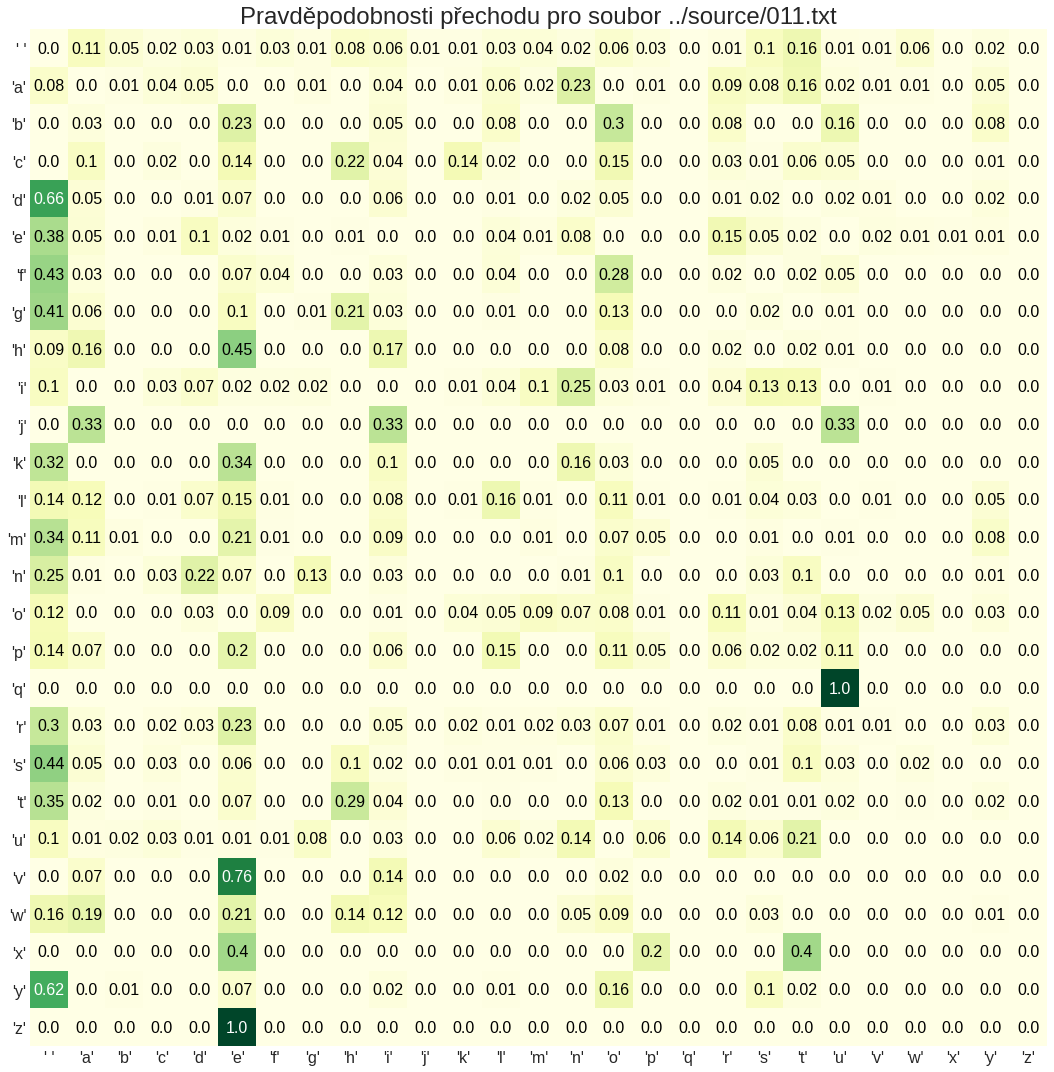

In [33]:
def create_transition_matrix(char_freq: dict):
    trans_mat = []

    for c1, v1 in char_freq.items():
        row = []
        for c2, v2 in v1.items():
            if c2 == 'count':
                continue
            if v1['count'] == 0:
                row.append(0)
                continue
            row.append(v2/v1['count'])
        trans_mat.append(row)
    return trans_mat

def print_heatmap(trans_matrix: list[list], unique_chars: list, f):
    trans_matrix = np.array(trans_matrix)
    fig, ax = plt.subplots()
    ax.imshow(trans_matrix, cmap='YlGn')

    ax.set_xticks(np.arange(len(unique_chars)))
    ax.set_yticks(np.arange(len(unique_chars)))

    ax.set_xticklabels(['\'{}\''.format(c) for c in unique_chars], fontsize=fontsize)
    ax.set_yticklabels(['\'{}\''.format(c) for c in unique_chars], fontsize=fontsize)

    for i in range(len(unique_chars)):
        for j in range(len(unique_chars)):
            if trans_matrix[i, j] > 0.5:
                text_color = 'w'
            else:
                text_color = '0'
            ax.text(j, i, round(trans_matrix[i, j], 2), ha="center", va="center", color=text_color, fontsize=fontsize)

    ax.set_title("Pravděpodobnosti přechodu pro soubor {}".format(f.name), fontsize=fontsize*1.5)
    fig.tight_layout()
    plt.show()


P1 = create_transition_matrix(freq_1)
print_heatmap(P1, unique_chars_1, f1)
P2 = create_transition_matrix(freq_2)
# print_heatmap(P2, unique_chars_2, f2)
# print(P1)



## 2. Na základě matice z předchozího bodu najděte stacionární rozdělení $$\boldsymbol{\pi}$$ tohoto řetězce pro **první** text.

In [34]:
def get_stationary_distribution(transition_matrix, unique_chars):
    pi = la.null_space(np.transpose(transition_matrix) - np.identity(len(unique_chars)))
    return np.transpose(pi/la.norm(pi, ord=1))

stat_dist_1 = get_stationary_distribution(P1, unique_chars_1)
print(stat_dist_1.round(3))
stat_dist_2 = get_stationary_distribution(P2, unique_chars_2)


[[0.206 0.059 0.013 0.015 0.039 0.088 0.017 0.014 0.053 0.049 0.002 0.01
  0.032 0.025 0.051 0.072 0.013 0.    0.042 0.049 0.077 0.025 0.007 0.019
  0.001 0.02  0.   ]]


## 3. Porovnejte rozdělení znaků druhého textu se stacionárním rozdělením $$\boldsymbol{\pi}$$, tj. na hladině významnosti 5 % otestujte hypotézu, že rozdělení znaků **druhého** textu se rovná rozdělení $$\boldsymbol{\pi}$$ z předchozího bodu.

In [35]:
def merge_bins(N, stat_dist_1):
    n = np.sum(N)
    p_j = np.array([np.sum(N, axis = 0)/n])

    npp = (np.matmul(stat_dist_1.reshape((-1,1)), p_j) * n).tolist()

    # Merge bins with values < 5
    tmp = [[0, 0], [0, 0]]
    indexes_to_remove = []
    for i in range(p_j.size):
        # Check if this column contains value < 5
        if npp[0][i] < 5 or npp[1][i] < 5:
            # If so, add value of theoretical and real frequencies to tmp variable
            for j in range(2):
                tmp[j][0] += npp[j][i]
                tmp[j][1] += N[j][i]
            indexes_to_remove.append(i)

            # If added theoretical frequencies are above 5, append them and real freq. to the end of list
            if tmp[0][0] >= 5 and tmp[1][0] >= 5:
                for j in range(2):
                    npp[j].append(tmp[j][0])
                    N[j].append(tmp[j][1])
                    tmp[j] = [0, 0]

    # Delete items with values < 5 from the list
    for index in sorted(indexes_to_remove, reverse=True):
        for j in range(2):
            del npp[j][index]
            del N[j][index]

    # Add remaining tmp value to lowest number in list
    if tmp[0][0] < tmp[1][0]:
        min_val_index = npp[0].index(min(npp[0]))
    else:
        min_val_index = npp[1].index(min(npp[1]))
    N[0][min_val_index] += tmp[0][1]
    N[1][min_val_index] += tmp[1][1]

    return N

# Create contingency table
N = [[v['count'] for v in freq_1.values()], [v['count'] for v in freq_2.values()]]
N = merge_bins(N, stat_dist_1)

alpha = 0.05
s, p, dof, _ = stats.chi2_contingency(N, correction = False)

print("Hypotézu H\N{SUBSCRIPT ZERO} zamítáme: ", s >= stats.chi2.isf(alpha, dof))
print("Hodnota testové statistiky: ", s)
print("p-hodnota:", p)


Hypotézu H₀ zamítáme:  True
33.92443847144379
Hodnota testové statistiky:  52.767317925630095
p-hodnota: 0.0002447144973627382
